In [1]:
import pandas as pd
import os
import tensorflow as tf
from keras import layers, models

import sys  
sys.path.append("../")  
from utils.modelgenerator import *
from utils.modelhandler import *
from utils.datahandler import *

In [2]:
#Get data 
cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.getcwd())))
df = pd.read_csv(cwd+'/data/3final_data/Final_Grossload_dataset.csv', index_col='Date')
df.index = pd.to_datetime(df.index)

#Select only 3 User for testing
df_user10 = df[['User10', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', 'User10_lag_24hrs']].head(8760)
df_user11 = df[['User11', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', 'User11_lag_24hrs']].head(8760)
df_user12 = df[['User12', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', 'User12_lag_24hrs']].head(8760)
df_array = [df_user10, df_user11, df_user12]
df_array[1].head(3)

,User11,temp,rhum,wspd,PC1,hour sin,hour cos,User11_lag_24hrs
Date,,,,,,,,
2010-07-02 00:00:00,0.766,2.5,92.0,0.0,-2.641741,0.000000,1.000000,0.817
2010-07-02 01:00:00,0.111,2.5,92.0,0.0,-2.641741,0.258819,0.965926,0.138
2010-07-02 02:00:00,0.112,2.5,92.0,0.0,-2.641741,0.500000,0.866025,0.108


In [3]:
#Train, Validation and Test datasets
sequence_length = 25
batch_size = 16
num_features = df_array[0].shape[1]

dh = Datahandler()

X_train, y_train, X_val, y_val, X_test, y_test = {}, {}, {}, {}, {}, {}

#Create Train, Validation and Test datasets
for idx, df in enumerate(df_array):
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    # Min max sclaing
    train_df = dh.min_max_scaling(train_df)
    val_df = dh.min_max_scaling(val_df)
    test_df = dh.min_max_scaling(test_df)

    # Sequencing
    train_sequences = dh.create_sequences(train_df, sequence_length)
    val_sequences = dh.create_sequences(val_df, sequence_length)
    test_sequences = dh.create_sequences(test_df, sequence_length)

    #Split into feature and label
    X_train[f'user1{idx}'], y_train[f'user1{idx}'] = dh.prepare_data(train_sequences, batch_size)
    X_val[f'user1{idx}'], y_val[f'user1{idx}'] = dh.prepare_data(val_sequences, batch_size)
    X_test[f'user1{idx}'], y_test[f'user1{idx}'] = dh.prepare_data(test_sequences, batch_size)

In [4]:
#General Hyperparameters
# #All models
horizon = 1
max_epochs = 100
m1 = ModelGenerator()
mh = Modelhandler()

loss = tf.keras.losses.MeanSquaredError()
metrics=[
    tf.keras.metrics.RootMeanSquaredError(), 
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanAbsoluteError(),
]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min')
timing_callback = TimingCallback()
custom_callback = CustomCallback()
callbacks=[early_stopping, timing_callback, custom_callback]

# 1.1 Dense MoE model

In [5]:
# Custom loss function for MoE model
def custom_mse_loss(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred)

# Additional loss function for importance regularization
class ImportanceRegularizationLayer(layers.Layer):
    def __init__(
            self, w_importance=0.001, min_importance=0.001, l2_weight=0, 
            dynamic_reg_strength=0.5, ortho_weight=0.001, sparse_weight=0, **kwargs
            ):
        super(ImportanceRegularizationLayer, self).__init__(**kwargs)
        self.w_importance = w_importance
        self.min_importance = min_importance
        self.l2_weight = l2_weight
        self.dynamic_reg_strength = dynamic_reg_strength
        self.ortho_weight = ortho_weight
        self.sparse_weight = sparse_weight

    def call(self, routing_logits, expert_outputs):
        
        # Balanced expert utilization
        # Calculate the importance of each expert relative to a batch of training examples
        expert_importance = tf.reduce_sum(routing_logits, axis=0)  # Batchwise sum of gate values for each expert
        # Calculate the coefficient of variation
        cv = tf.math.reduce_std(expert_importance) / tf.math.reduce_mean(expert_importance)
        # Importance loss is the square of the coefficient of variation multiplied by the scaling factor
        cv_loss = self.w_importance * tf.square(cv)
        # Penalty for importance values close to 0
        min_importance_penalty = tf.reduce_sum(tf.nn.relu(self.min_importance - expert_importance))

        # L2 regularization term
        if self.l2_weight != 0:
            l2_loss = self.l2_weight * tf.reduce_sum(tf.square(expert_importance))
        else: 
            l2_loss = 0
        
        # Normalize expert outputs
        reshaped_expert_outputs = tf.reshape(expert_outputs, [16 * 24, 4 * 8])
        expert_outputs_norm = tf.nn.l2_normalize(reshaped_expert_outputs, axis=-1)
        # Compute the inner product of normalized expert outputs
        outputs_inner_product = tf.matmul(expert_outputs_norm, expert_outputs_norm, transpose_b=True)
        # Penalize similarity of outputs
        outputs_ortho_loss = self.ortho_weight * tf.reduce_sum(tf.square(outputs_inner_product - tf.eye(tf.shape(outputs_inner_product)[0])))

        # Normalize expert weights
        expert_weights_norm = tf.nn.l2_normalize(expert_outputs, axis=0)
        # Compute the inner product of normalized expert weights
        weights_inner_product = tf.matmul(expert_weights_norm, expert_weights_norm, transpose_a=True)
        # Penalize similarity of weights
        weights_ortho_loss = self.ortho_weight * tf.reduce_sum(tf.square(weights_inner_product))

        # Combine the penalties
        combined_ortho_loss = outputs_ortho_loss + weights_ortho_loss  # Or use a different combination strategy

        # Sparsity regularization term
        sparse_loss = self.sparse_weight * tf.reduce_sum(tf.abs(expert_importance))

        # Total loss is the sum of individual losses
        loss = cv_loss + min_importance_penalty + l2_loss + combined_ortho_loss + sparse_loss

        # Add the importance loss to the model's loss
        self.add_loss(loss, inputs=routing_logits)

        # Update dynamic regularization strength for cv_loss
        self.w_importance *= self.dynamic_reg_strength
        self.ortho_weight *= self.dynamic_reg_strength

        return routing_logits
    
#Builds a MoE model with soft gating
def build_soft_dense_moe_model(X_train, batch_size, horizon, dense_units,  expert_units, num_experts, m1):
    #Input of shape (batch_size, sequence_length, features)
    inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]), batch_size=batch_size, name='input_layer') 
    x = inputs


    #EMBEDDED MOE LAYER
    # Gating network (Routing Softmax)
    routing_logits = layers.Dense(num_experts, activation='softmax')(x)

    #experts
    experts = [m1.build_expert_network(expert_units=expert_units)(x) for _ in range(num_experts)]
    expert_outputs = tf.stack(experts, axis=1)
    #Add and Multiply expert models with router probability
    moe_output = tf.einsum('bsn,bnse->bse', routing_logits, expert_outputs)
    #END MOE LAYER

    # Add ImportanceRegularizationLayer to the model
    importance_regularizer = ImportanceRegularizationLayer()
    routing_logits = importance_regularizer(routing_logits, expert_outputs)

    x = layers.Dense(dense_units, activation="relu")(moe_output)
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(horizon)(x)

    softgated_moe_model = models.Model(inputs=inputs, outputs=outputs, name="soft_dense_moe")
    softgated_moe_model.compile(loss=custom_mse_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=metrics)
    
    return softgated_moe_model

In [7]:
#Builds a MoE model with top_k gating
def build_topk_dense_moe_model(X_train, batch_size, horizon, dense_units, num_experts, top_k, expert_units, m1):
    #Input of shape (batch_size, sequence_length, features)
    inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]), batch_size=batch_size, name='input_layer') 
    x = inputs

    router_inputs = x
    router_probs = layers.Dense(num_experts, activation='softmax')(router_inputs)
    expert_gate, expert_index = tf.math.top_k(router_probs, k=top_k)
    expert_idx_mask = tf.one_hot(expert_index, depth=num_experts)
    
    combined_tensor = layers.Lambda(lambda x: tf.einsum('abc,abcd->abd', x[0], x[1]))([expert_gate, expert_idx_mask])
    expert_inputs = layers.Lambda(lambda x: tf.einsum("abc,abd->dabc", x[0], x[1]))([router_inputs, combined_tensor])
    expert_input_list = tf.unstack(expert_inputs, axis=0)
    expert_output_list = [
            [m1.build_expert_network(expert_units=expert_units) for _ in range(num_experts)][idx](expert_input)
            for idx, expert_input in enumerate(expert_input_list)
        ]
    expert_outputs = tf.stack(expert_output_list, axis=1)
    expert_outputs_combined = layers.Lambda(lambda x: tf.einsum("abcd,ace->acd", x[0], x[1]))([expert_outputs, combined_tensor])
    moe_output = expert_outputs_combined

    # Add ImportanceRegularizationLayer
    importance_layer = ImportanceRegularizationLayer()
    _ = importance_layer(router_probs, expert_outputs)

    #BOTTOM Model
    x = layers.Dense(dense_units)(moe_output) 
    x = layers.Dense(dense_units, activation="relu")(x)
    
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(horizon)(x)
    topk_moe_model = models.Model(inputs=inputs, outputs=outputs, name="topk_moe")
    topk_moe_model.compile(loss=custom_mse_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=metrics)

    return topk_moe_model

'#Builds a MoE model with top_k gating\ndef build_topk_dense_moe_model(X_train, batch_size, horizon, dense_units, num_experts, top_k, expert_units, m1):\n    #Input of shape (batch_size, sequence_length, features)\n    inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]), batch_size=batch_size, name=\'input_layer\') \n    x = inputs\n\n    router_inputs = x\n    router_probs = layers.Dense(num_experts, activation=\'softmax\')(router_inputs)\n    expert_gate, expert_index = tf.math.top_k(router_probs, k=top_k)\n    expert_idx_mask = tf.one_hot(expert_index, depth=num_experts)\n    \n    combined_tensor = layers.Lambda(lambda x: tf.einsum(\'abc,abcd->abd\', x[0], x[1]))([expert_gate, expert_idx_mask])\n    expert_inputs = layers.Lambda(lambda x: tf.einsum("abc,abd->dabc", x[0], x[1]))([router_inputs, combined_tensor])\n    expert_input_list = tf.unstack(expert_inputs, axis=0)\n    expert_output_list = [\n            [m1.build_expert_network(expert_units=expert_units) for _ in

In [11]:
def build_topk_dense_moe_model(X_train, batch_size, horizon, dense_units, num_experts, top_k, expert_units, m1):
    # Input of shape (batch_size, sequence_length, features)
    inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]), batch_size=batch_size, name='input_layer')
    x = inputs

    # Gating mechanism
    router_inputs = inputs
    router_probs = layers.Dense(num_experts, activation='softmax')(router_inputs)
    _, expert_index = tf.math.top_k(router_probs, k=top_k)

    # Use tf.gather to select the top k experts' inputs
    expert_input_list = [tf.gather(router_inputs, indices, axis=-1) for indices in tf.unstack(expert_index, axis=-1)]

    # Building and applying expert networks
    expert_output_list = []
    for expert_input in expert_input_list:
        expert_output = []
        for idx in range(num_experts):
            expert_network = m1.build_expert_network(expert_units=expert_units)
            expert_output.append(expert_network(expert_input))
        expert_output_list.append(tf.stack(expert_output, axis=1))

    # Combining outputs from the top k experts
    expert_outputs_combined = tf.reduce_sum(tf.stack(expert_output_list, axis=2), axis=2)

    # BOTTOM Model
    x = layers.Dense(dense_units)(expert_outputs_combined)
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(horizon)(x)
    topk_moe_model = models.Model(inputs=inputs, outputs=outputs, name="topk_moe")
    topk_moe_model.compile(loss=custom_mse_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=metrics)

    return topk_moe_model

In [9]:
dense_moe_results = pd.DataFrame(columns=['architecture', 'Loss@User10','std@User10', 'Loss@User11','std@User11', 'Loss@User12','std@User12'])

In [12]:
#Dense Hyperparameter
dense_moe_architecture = "2xd16_sE4d8_d16"
dense_units = 16

num_experts = 4
expert_units = 8
top_k = 2

dense_moe_all_results = pd.DataFrame(columns=["user", "architecture", "mse"])
#For each of the 3 user
for idx in range(3):
    print("User: ", idx)
    for round in range(3):
        #print("Round: ", round) 
        #dense_moe_model = build_soft_dense_moe_model(X_train[f'user1{idx}'], batch_size, horizon, dense_units, expert_units, num_experts, m1)
        dense_moe_model = build_topk_dense_moe_model(X_train[f'user1{idx}'], batch_size, horizon, dense_units, num_experts, top_k, expert_units, m1)
        
        history = dense_moe_model.fit(
            X_train[f'user1{idx}'], y_train[f'user1{idx}'], epochs=max_epochs, batch_size=batch_size, 
            validation_data=(X_val[f'user1{idx}'], y_val[f'user1{idx}']), callbacks=callbacks, verbose=0
            )
        #Evaluate the model on test dataset
        test_loss = dense_moe_model.evaluate(X_test[f'user1{idx}'], y_test[f'user1{idx}'], batch_size=batch_size, verbose=0)

        train_times = callbacks[1].get_training_times_df()
        total_train_time = train_times["Total Training Time"][0]
        avg_time_epoch = train_times["Epoch Avg Train_time"].iloc[-1]
    
        model_user_result = pd.DataFrame(
            data=[[f'user1{idx}', dense_moe_architecture, total_train_time, avg_time_epoch, test_loss[0], test_loss[1], test_loss[2], test_loss[3]]], 
            columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"]
        )
        
        # Add the 'architecture' column from dense_user_results to dense_results
        dense_moe_all_results = pd.merge(dense_moe_all_results, model_user_result, how='outer')   

new_row = {
    'architecture': dense_moe_all_results["architecture"][0],
    'Loss@User10': dense_moe_all_results[dense_moe_all_results["user"]=="user10"]["mse"].mean(),
    'std@User10' : dense_moe_all_results[dense_moe_all_results["user"]=="user10"]["mse"].std(),
    'Loss@User11': dense_moe_all_results[dense_moe_all_results["user"]=="user11"]["mse"].mean(),
    'std@User11' : dense_moe_all_results[dense_moe_all_results["user"]=="user11"]["mse"].std(),
    'Loss@User12': dense_moe_all_results[dense_moe_all_results["user"]=="user12"]["mse"].mean(),
    'std@User12' : dense_moe_all_results[dense_moe_all_results["user"]=="user12"]["mse"].std(),
}
dense_moe_results.loc[len(dense_moe_results)] = new_row

User:  0

User:  1
User:  2


In [13]:
dense_moe_results["mean"] = dense_moe_results[['Loss@User10', 'Loss@User11', 'Loss@User12']].mean(axis=1)
#lstm_results.drop(labels=['Unnamed: 0', 'sum'], axis=1,  inplace=True)
dense_moe_results

,architecture,Loss@User10,std@User10,Loss@User11,std@User11,Loss@User12,std@User12,mean
0,2xd16_sE4d8_d16,0.017387,0.002586,0.02203,0.00484,0.016242,0.002247,0.018553


53/53 [==============================] - 0s 1ms/step


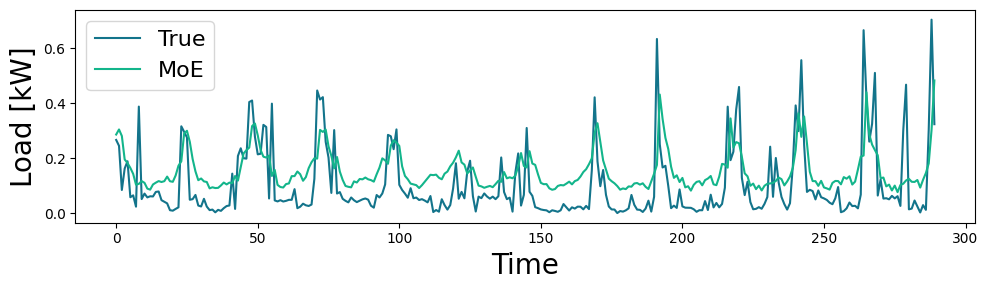

In [53]:
y_pred_dense_moe_model = dense_moe_model.predict(X_test['user10'], batch_size=batch_size)


# Plot prediction results
fig = plt.figure(figsize=(10, 3))
plt.plot(y_test['user10'][5:295], label='True', color='#13748B')
plt.plot(y_pred_dense_moe_model[5:295], label='MoE',color='#13B58B')
plt.xlabel('Time', fontsize=20)
plt.ylabel('Load [kW]', fontsize=20)
plt.legend(fontsize=16)
plt.tight_layout()